### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import sklearn
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
import scipy
from scipy.stats import pearsonr

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

### read the data

In [4]:
sales = pd.read_csv('train.csv').set_index('date')
oil = pd.read_csv('oil.csv')
stores = pd.read_csv('stores.csv')
holidays = pd.read_csv('holidays_events.csv')

we're selecting a single store to forecast it's sales. In the previous notebook, we saw that store 44 has the highest number sales, so we will proceed with it

In [5]:
sales = sales[sales['store_nbr']==44].groupby('date').sum()[['sales','onpromotion']].drop('2013-01-01').reset_index()
sales.head()

,date,sales,onpromotion
0,2013-01-02,30095.181,0
1,2013-01-03,20447.057,0
2,2013-01-04,22795.799,0
3,2013-01-05,31382.508,0
4,2013-01-06,36069.345,0


In [6]:
# joining sales data with oil data
data = pd.merge(left=sales,right=oil,on='date',how='left')

# rename the oil price column
data.rename({'dcoilwtico':'oil_price'},axis=1, inplace=True)

# fill empty values of oil price
data['oil_price'] = data['oil_price'].fillna(method='ffill')
data.head()

,date,sales,onpromotion,oil_price
0,2013-01-02,30095.181,0,93.14
1,2013-01-03,20447.057,0,92.97
2,2013-01-04,22795.799,0,93.12
3,2013-01-05,31382.508,0,93.12
4,2013-01-06,36069.345,0,93.12


In [7]:
# one-hot encoding the different holiday columns
locale_name = pd.get_dummies(holidays['locale_name'])
locale = pd.get_dummies(holidays['locale'])
holiday_type = pd.get_dummies(holidays['type'])

# joining all one-hot encoded columns
holidays = pd.concat([
    holidays[['date','transferred']],
    locale,
    locale_name,
    holiday_type]
    ,axis=1
)

holidays = holidays.groupby('date').mean().reset_index()


# joining holidays table with current data. now this table cotains: sales data, oil data, holidays data
data = pd.merge(left=data,right=holidays,on='date',how='left').fillna(0)

In [8]:
# adding day of week to the data
day_of_week = pd.get_dummies(pd.to_datetime(data['date']).dt.dayofweek)
data = pd.concat([data,day_of_week],axis=1)
data.shape

(1683, 45)

### windowing the data to create features and labels

In [9]:
x = np.array([])
y = np.array([])
lookback = 6
for i in range(lookback,len(data)):
    x = np.append(x, data.iloc[i-lookback:i][data.columns[1:]].values.reshape(1,-1) )
    y = np.append(y, data.iloc[i]['sales'] )
        
x = x.reshape(-1,(data.shape[1]-1)*lookback)

In [10]:
x.shape, y.shape

((1677, 264), (1677,))

### train test split

In [11]:
x_train = x[:-100]
y_train = y[:-100]
x_test = x[-100:]
y_test = y[-100:]

In [12]:
# initialize random forest regressor model
model = RandomForestRegressor()

# fit the model
model.fit(x_train,y_train)

# make predictions
pred = model.predict(x_test)

pred.shape

(100,)

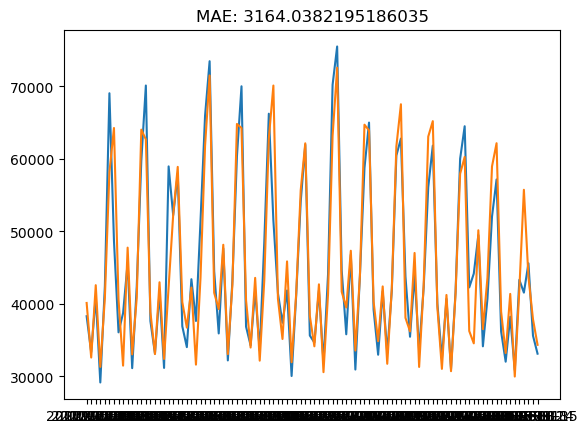

In [13]:
# get number of test days
test_days = len(pred)

# plot actual sales
plt.plot(
    data['date'].iloc[-test_days:],
    y_test
)

# plot predicted sales
plt.plot(
    data['date'].iloc[-test_days:],
    pred
)

# title and legend
plt.title(
    f"MAE: {abs(pred-y_test).mean()}"
)
    
plt.show()

### we have many features in the model since each feature is repeated 6 times (due to windowing)
so we'll sum all the different windows so that each feature name will have a single importance value

In [14]:
# get the feature importance from the random forest model
importance = pd.DataFrame(model.feature_importances_.reshape(lookback,(data.shape[1]-1)))

# set the names of the features
importance.columns = data.columns[1:]

# sum across all windows and sort descending
importance.sum().sort_values(ascending=False)

sales                             0.576163
onpromotion                       0.110730
3                                 0.070584
4                                 0.059595
1                                 0.036110
0                                 0.027005
5                                 0.026187
2                                 0.023987
oil_price                         0.016888
6                                 0.009628
Additional                        0.009199
Ecuador                           0.004548
National                          0.004481
Holiday                           0.003491
Libertad                          0.003339
Event                             0.002574
Regional                          0.002176
Local                             0.001780
Cuenca                            0.001645
Bridge                            0.001365
transferred                       0.000963
Santa Elena                       0.000899
Santo Domingo de los Tsachilas    0.000875
Guaranda   

# Conclusion:
out of the two methods we tried, we found that random forest on a windowed dataset yeilds better results than the arima variants